In [4]:
import os
import pickle
import hickle as hkl

from scipy import *               
from numpy import *                
import pdb
import scipy.io

import numpy as np

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [5]:
plt.style.use("seaborn")
sns.set_style("whitegrid")
sns.set_context("talk")

In [6]:
# Adapted https://github.com/zhegan27/TSBN_code_NIPS2015/blob/master/bouncing_balls/data/data_handler_bouncing_balls.py

"""
This script comes from the RTRBM code by Ilya Sutskever from 
http://www.cs.utoronto.ca/~ilya/code/2008/RTRBM.tar
"""


shape_std=shape
def shape(A):
    return A.shape

size_std = size
def size(A):
    if isinstance(A, ndarray):
        return size_std(A)
    else:
        return A.size()

det = linalg.det

def new_speeds(m1, m2, v1, v2):
    new_v2 = (2*m1*v1 + v2*(m2-m1))/(m1+m2)
    new_v1 = new_v2 + (v2 - v1)
    return new_v1, new_v2
    

def norm(x): return sqrt((x**2).sum())
def sigmoid(x):        return 1./(1.+np.exp(-x))

SIZE=10
# size of bounding box: SIZE X SIZE.


def bounce_n(M, T, n=2, r=None, m=None):
    """
    M (int) - number of time points in [0, T]
    T (float) - terminal time.
    """

    if r is None: r=array([1.2]*n)
    if m==None: m=array([1]*n)
    # r is to be rather small.
    X=zeros((M, n, 2), dtype='float')
    V=zeros((M, n, 2), dtype='float')
    v = np.random.randn(n,2)
    v = v / norm(v)*.5
    good_config=False
    while not good_config:
        x = 2+np.random.rand(n,2)*8
        good_config=True
        for i in range(n):
            for z in range(2):
                if x[i][z]-r[i]<0:      good_config=False
                if x[i][z]+r[i]>SIZE:     good_config=False

        # that's the main part.
        for i in range(n):
            for j in range(i):
                if norm(x[i]-x[j])<r[i]+r[j]:
                    good_config=False
                    
    
    X[0] = x.copy()
    V[0] = v.copy()

    step_size = T / (M - 1)
    for t in range(1, M):
        # for how long do we show small simulation

        for i in range(n):
            x[i]+=step_size*v[i]
        
        for i in range(n):
            for z in range(2):
                if x[i][z]-r[i]<0:  v[i][z]= abs(v[i][z]) # want positive
                if x[i][z]+r[i]>SIZE: v[i][z]=-abs(v[i][z]) # want negative

        for i in range(n):
            for j in range(i):
                if norm(x[i]-x[j])<r[i]+r[j]:
                    # the bouncing off part:
                    w    = x[i]-x[j]
                    w    = w / norm(w)

                    v_i  = dot(w.transpose(),v[i])
                    v_j  = dot(w.transpose(),v[j])

                    new_v_i, new_v_j = new_speeds(m[i], m[j], v_i, v_j)
                    
                    v[i]+= w*(new_v_i - v_i)
                    v[j]+= w*(new_v_j - v_j)

        X[t] = x.copy()
        V[t]= v.copy()

    return X, V

def ar(x,y,z):
    return z/2+arange(x,y,z,dtype='float')

def matricize(X,res,r=None):

    T, n= shape(X)[0:2]
    if r is None: r=array([1.2]*n)

    A=zeros((T,res,res), dtype='float')
    
    [I, J]=meshgrid(ar(0,1,1./res)*SIZE, ar(0,1,1./res)*SIZE)

    for t in range(T):
        for i in range(n):
            A[t]+= np.exp(-(  ((I-X[t,i,0])**2+(J-X[t,i,1])**2)/(r[i]**2)  )**4    )
            
        A[t][A[t]>1]=1
    return A

def bounce_mat(res, n=2, T=128, r =None):
    if r is None: r=array([1.2]*n)
    x, vel = bounce_n(T,n,r);
    A = matricize(x,res,r)
    return A

def bounce_vec(res, n=2, T=128, M=50, r =None, m =None):
    if r is None: r=array([1.2]*n)
    x, vel = bounce_n(M,T,n,r,m);
    V = matricize(x,res,r)

    x = x.reshape(x.shape[0], -1)
    vel = vel.reshape(x.shape[0], -1)

    return V.reshape(M, res**2), np.concatenate((x, vel), axis=1)


def pickle_data(data_dict: dict[str, list], path: str ="./") -> None:
    if not os.path.isdir(path):
        os.makedirs(path)
    for name, data in data_dict.items():
        with open(path+name+".pkl", "wb") as f:
            pickle.dump(data, f, protocol=4)

            
def subsample_min_dist(t, n, min_dist):
    """Subsamples `n` time points from `t` while keeping the smallest distance
    between the time points at least `min_dist`. Note: returns only indices, not time points.
    """
    assert n <= len(t), "Too large `n`."
    assert min_dist <= (t.max() - t.min()) / (n - 1), "Too large `min_dist`."
    inds = [0, len(t)-1]
    for i in range(n-2):
        c, c_max = 0, 1e4
        while True:
            ind_i = np.random.choice(len(t), size=1)
            dists = np.abs(t[inds] - t[ind_i])
            if all(dists >= min_dist):
                inds.append(ind_i.item())
                break
            if c > c_max:
                raise RuntimeError("Failed to subsample the time grid. Use smalled `n` or `min_dist`.")
            c += 1
    return sorted(inds)


def generate_data(T, M, imgs_size, n_balls, dt, ball_sizes=array([1., 1., 1.]), regular=False, seed=None):
    t_fine = np.arange(0.0, T+dt*0.1, dt)
    y_fine, y_raw_fine = bounce_vec(res=imgs_size, n=n_balls, T=T, M=len(t_fine), r=ball_sizes)

    if regular is True:
        inds = np.arange(0, len(t_fine), int(len(t_fine)/(M-1)))
    else:
        inds = subsample_min_dist(t_fine, M, min_dist=0.25*T/(M-1))

    t, y, y_raw = t_fine[inds], y_fine[inds], y_raw_fine[inds]
    y = y[None, :, None, :].astype(np.float32)  # reshape to (1, M, 1, D)
    y_raw = y_raw[None, :, :].astype(np.float32)  # reshape to (1, M, n_balls*4)

    return t, y, y_raw

In [10]:
# Find the right step size for the given T first
# T = 50 good with step size 0.01
# T = 20 good with step size 0.1

# T = 20
# for dt_i in [1, 0.1, 0.01]:  # 0.5, 0.1, 0.01, 0.005
#     np.random.seed(1309)
#     x, _ = bounce_vec(res=32, n=3, T=T, M=int(T/dt_i)+1)
#     print(int(T/dt_i)+1)

#     plt.imshow(x[-1].reshape(32, 32))
#     plt.title(f"M={int(T/dt_i)+1} dt={dt_i}")
#     plt.show()

### Generate data

In [19]:
SEED = 1545

S = 12000  # number of simulations
M = 51  # number of time points
T = 20  # terminal time
regular = False  # regular/irregular grid flag

img_size = 32  # image size (img_size x img_size)
n_balls = 3  # nubmer of balls

t = []  # time grids
y = []  # data (image)
y_raw = []  # data (positions and velocities)

ball_sizes = np.array([1.2, 1.2, 1.2])  # radii of the balls
dt = 0.1

np.random.seed(SEED)
# for i in tqdm(range(S), total=S):
for i in range(S):
    t_i, y_i, y_raw_i =  generate_data(T, M, img_size, n_balls, dt, ball_sizes, regular=regular, seed=None)
    t.append(t_i.reshape(-1, 1))
    y.append(y_i[0])
    y_raw.append(y_raw_i[0])
    if i % 100 == 0:
        print(i)

a, b = int(0.833333334*S), int(0.916666667*S)
t_train, t_val, t_test = t[0:a], t[a:b], t[b:]
y_train, y_val, y_test = y[0:a], y[a:b], y[b:]
y_raw_train, y_raw_val, y_raw_test = y_raw[0:a], y_raw[a:b], y_raw[b:]

if regular:
    pickle_data({"t": t_train, "y": y_train, "y_raw": y_raw_train}, path=f"../datasets/bballs_unif/train/")
    pickle_data({"t": t_val, "y": y_val, "y_raw": y_raw_val}, path=f"../datasets/bballs_unif/val/")
    pickle_data({"t": t_test, "y": y_test, "y_raw": y_raw_test}, path=f"../datasets/bballs_unif/test/")
else:
    pickle_data({"t": t_train, "y": y_train, "y_raw": y_raw_train}, path=f"../datasets/bballs/train/")
    pickle_data({"t": t_val, "y": y_val, "y_raw": y_raw_val}, path=f"../datasets/bballs/val/")
    pickle_data({"t": t_test, "y": y_test, "y_raw": y_raw_test}, path=f"../datasets/bballs/test/")

0


### Look at the data

In [20]:
print(
    f"Minimum number of time points: {np.min([ti.shape[0] for ti in t])}\n"
    f"Maximum number of time points: {np.max([ti.shape[0] for ti in t])}\n\n"

    f"Minimum time: {np.min([ti[0, 0] for ti in t])}\n"
    f"Maximum time: {np.max([ti[-1, 0] for ti in t])}\n\n"

    f"Minimum temporal distance: {np.min([np.diff(ti.ravel()) for ti in t]):.3f}\n"
    f"Maximum temporal distance: {np.max([np.diff(ti.ravel()) for ti in t]):.3f}\n\n"
)

Minimum number of time points: 51
Maximum number of time points: 51

Minimum time: 0.0
Maximum time: 20.0

Minimum temporal distance: 0.100
Maximum temporal distance: 2.700




Minimum number of time points before 3.000 sec.: 4
Minimum number of time points before 3.000 sec.: 14


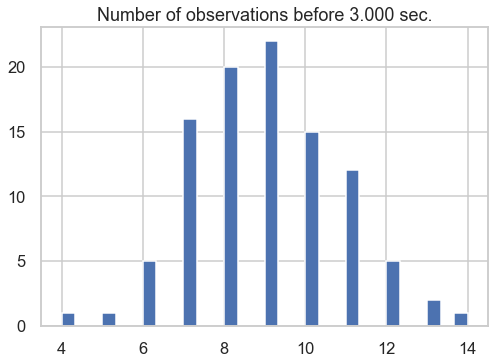

In [21]:
t_inf = 0.15*T
t_inf_size = np.array([sum(ti.ravel() <= t_inf) for ti in t])

print(
    f"Minimum number of time points before {t_inf:.3f} sec.: {np.min(t_inf_size)}\n"
    f"Minimum number of time points before {t_inf:.3f} sec.: {np.max(t_inf_size)}"
)

plt.hist(t_inf_size, bins=30)
plt.title(f"Number of observations before {t_inf:.3f} sec.")
plt.show()

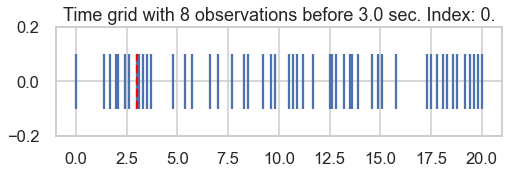

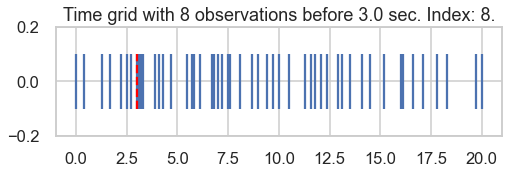

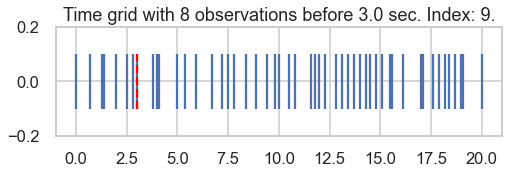

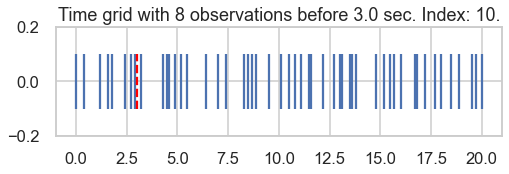

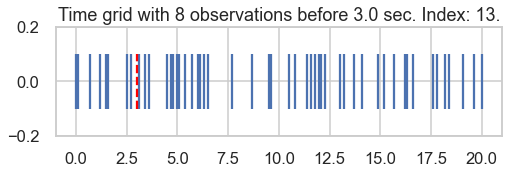

In [22]:
target_size = 8
inds_for_size = np.argwhere(t_inf_size == target_size).ravel()

for i in range(min(5, len(inds_for_size))):
    fig, ax = plt.subplots(1, 1, figsize=(8, 2))
    ax.vlines(t[inds_for_size[i]].ravel(), -0.1, 0.1)
    ax.vlines(t_inf, -0.1, 0.1, color="r", linestyle="--")
    ax.set_ylim(-0.2, 0.2)
    ax.set_title(f"Time grid with {target_size} observations before {t_inf:.1f} sec. Index: {inds_for_size[i]}.")
    plt.show()

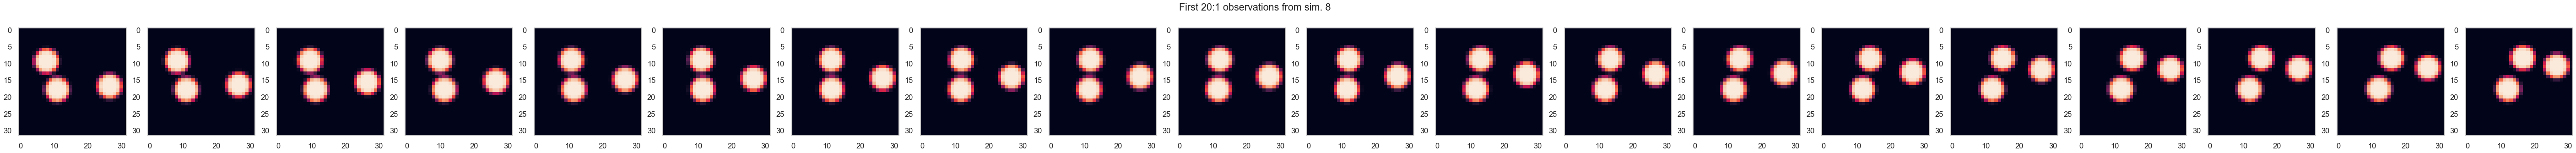

In [23]:
sim_ind = 8
n, skip = 20, 1
fig, ax = plt.subplots(1, n, figsize=(n*5, 5))
for i in range(n):
    ax[i].grid(False)
    ax[i].imshow(y[sim_ind][i*skip, :, :].astype(np.float32).reshape(32, 32))
fig.suptitle(f"First {n*skip}:{skip} observations from sim. {sim_ind}")
plt.show()

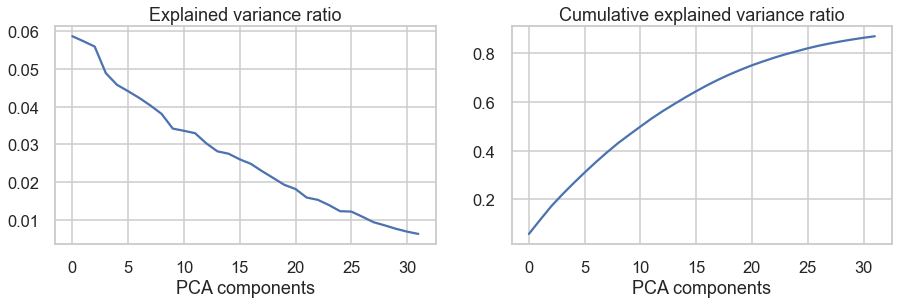

In [16]:
pca_input = []
for yi in y:
    pca_input.extend(yi[:, 0, :])
pca_input = np.array(pca_input)

pca = PCA(n_components=32, whiten=False)
pca_output = pca.fit_transform(pca_input)


fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(pca.explained_variance_ratio_)
ax[0].set_title("Explained variance ratio")
ax[0].set_xlabel("PCA components")

ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
ax[1].set_title("Cumulative explained variance ratio")
ax[1].set_xlabel("PCA components")

plt.show()

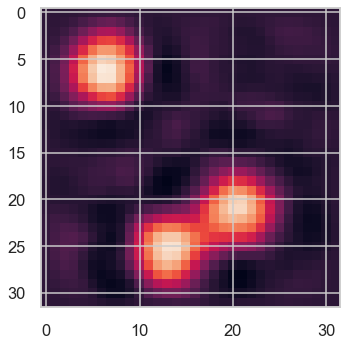

In [18]:
plt.imshow(pca.inverse_transform(pca_output[0]).reshape(32, 32));